# Data Enabled Predictive Control(DeePC)
This notebook will demonstrate a python implementation of Data Enabled Predictive Control (DeePC).

It will demonstrate DeePC on a simple Double Integrator

In [ ]:
# Imports
import numpy as np
from cvxopt import spmatrix, matrix, solvers
from numpy import linalg as nla
from scipy import linalg as sla
from scipy import sparse
from scipy.signal import cont2discrete
from scipy.stats import qmc
from scipy.linalg import svd
from cvxopt.solvers import qp
import cvxpy as cp
from numpy import hstack, inf, ones
from scipy.sparse import vstack
from osqp import OSQP
import matplotlib.pyplot as plt
from matplotlib import  rcParams
# Background color settings to match the plots with the presentation theme
# plt.rcParams['figure.facecolor'] = '#F6F6F8'
# plt.rcParams['axes.facecolor'] = '#F6F6F8'
# rcParams['figure.facecolor'] = '#F6F6F8'
# rcParams['axes.facecolor'] = '#F6F6F8'
from matplotlib import rc
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import Normalize
import time
import importlib
import systems  # Replace with the module you are working on
import utils
from tqdm import tqdm

# TODO Replace with Pendulum notes

### Double Integrator

A simple n-dimensional double integrator can be written as:

$ \dot{x} = Ax + Bu $

$ y = Cx + Du $

Where:
- $x$ is the state vector: $x = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}, v_{x_1}, v_{x_2}, \ldots, v_{x_n}]^T$
- $u$ is the control input: $u = [a_{x_1}, a_{x_2}, \ldots, a_{x_n}]^T$
- $y$ is the output vector: $y = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}]^T$
- $A$, $B$, $C$, and $D$ are the system matrices

These matricies are defined as:

$A = \begin{bmatrix}
\mathbf{0} & I_n \\
\mathbf{0} & \mathbf{0}
\end{bmatrix} $


$ B = \begin{bmatrix}
\mathbf{0} \\
I_n
\end{bmatrix} $

$ C = \begin{bmatrix}
I_n & \mathbf{0}
\end{bmatrix} $

$ D = \mathbf{0} $

For this demonstration, we will use a 2-dimensional double integrator, which means $n=2$. The double integrator has been implemented in the `systems` module, which can be found in the `systems.py` file.

I will be using [cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) from scipy to discretize the system.

In [ ]:
from systems import InvertedPendulum
importlib.reload(systems)  # Reload the module

<module 'systems' from 'c:\\Users\\sanji\\Documents\\School\\Classes\\271D\\Final Project\\systems.py'>

In [ ]:
from utils import block_hankel, DeePC, DeePC_LRA
importlib.reload(utils)
# For more info, look at the DeePC notebook

### Extension: Testing on a Nonlinear System
We will test DeePC on an inverted pendulum

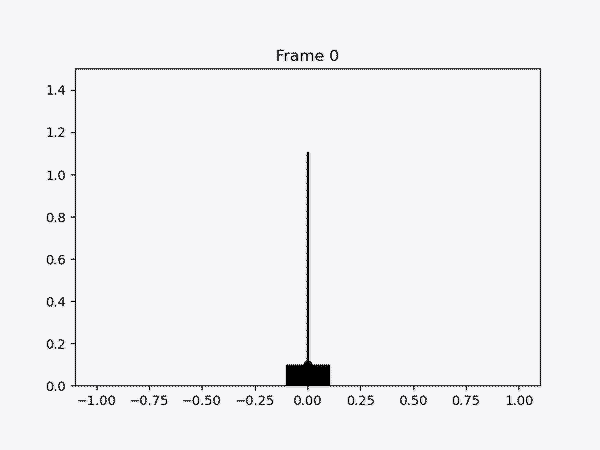

In [ ]:
pendulum_input_box_constraints = [[-5, 5]]  # Torque input constraints
pendulum_output_box_constraints = [[-np.pi, np.pi]]  # Angle constraints
inverted_pendulum = InvertedPendulum(dt=0.01, input_box_constraints=pendulum_input_box_constraints, y_box_constraints=pendulum_output_box_constraints, noise_profile=((np.zeros(1), 0 * np.eye(1))))

inverted_pendulum.y_box_constraints = None
for t in range(200):
    y, _ = inverted_pendulum.step([1])  # constant torque input

# inverted_pendulum.plot_trajectory(save_file='test_pendulum_trajectory.gif')
from IPython.display import Image
Image(open('test_pendulum_trajectory.gif','rb').read())

In [655]:
from systems import InvertedPendulum
importlib.reload(systems)  # Reload the module

# Now that we have a pendoulum system, we can apply DeePC to it
# Some Hyperparameters to setup
order_estimate = 10

inverted_pendulum = InvertedPendulum(dt=0.01, input_box_constraints=pendulum_input_box_constraints, y_box_constraints=pendulum_output_box_constraints, noise_profile=((np.zeros(1), 0 * np.eye(1))))

# Data Collection parameters
deepc = DeePC(inverted_pendulum, T=T, order_estimate=order_estimate) # create an instance of DeePC

Offline Data Collection is challenging, since the system is unstable, so we cannot just provide random inputs to the system. We will use a PD controller with high gains to stabilize the system and collect data around different setpoints, which should hopefully give us a good coverage of the state space.

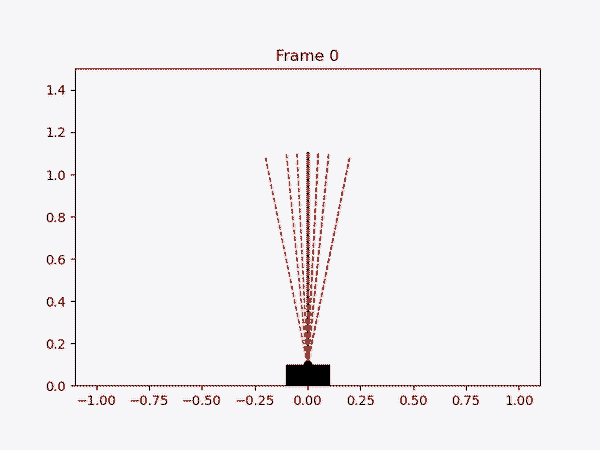

In [656]:
inverted_pendulum_test = InvertedPendulum(dt=0.01, input_box_constraints=pendulum_input_box_constraints, noise_profile=((np.zeros(1), 0 * np.eye(1))))
# we will use the test system to create a set of control inputs to use as the initial dataset.
# By visually inspecting the trajectory, we can see that the system is rich enough to learn from.
N = 100 # Number of steps it can take before switching to a different setpoint
setpoints = [0.05, 0.1, 0.2, 0, -0.05, -0.1, -0.2, -0.1]
U = []
for setpoint in setpoints:
	prev_error = setpoint - inverted_pendulum_test.y  # Reset error when changing setpoint
	for _ in range(N):
		# create a control input that will drive the system to the setpoint
		error = setpoint - inverted_pendulum_test.y
		d_error = error - prev_error  
		prev_error = error
		u = [np.squeeze(np.array(max(min(50*error + 500*d_error, 4), -4)))]
		U.append(u)
		inverted_pendulum_test.step(u)

# inverted_pendulum_test.plot_trajectory(show_theta=setpoints, save_file='test_pendulum_initial_data.gif')
from IPython.display import Image
Image(open('test_pendulum_initial_data.gif','rb').read())

Visually, this dataset seems like it has a good coverage of the state space and even captures the system failing at the end, so we can use this data to train the DeePC controller.

In [665]:
deepc.collect_offline_data(U=U)  # Collect data using the control inputs we created


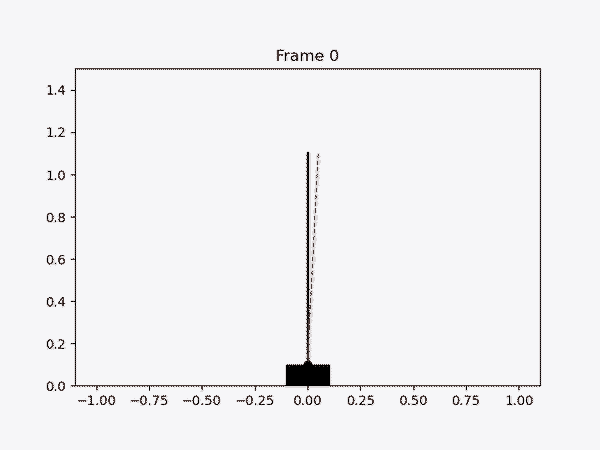

In [666]:
# Getting the initial condition
true_start = np.array([0.05, 0.05])  # Starting point before we start MPC control
des_start = np.array([0])  # We want to take it to a small angle, while we estimate the initial condition
N = 100  # Number of steps to take to reach the desired starting point

inverted_pendulum.delete_history()  # Clear the history of the system
inverted_pendulum.set_state(true_start)  # Set the initial state
prev_error = des_start - inverted_pendulum.y
for _ in range(N):
	error = des_start - inverted_pendulum.y
	d_error = error - prev_error
	prev_error = error
	u = [np.squeeze(np.array(max(min(50*error + 500*d_error, 4), -4)))]
	deepc.step_and_collect(u)  # Proportional-Derivative control to reach the desired starting point
# inverted_pendulum.plot_trajectory(show_theta=[0], save_file='test_pendulum_initial_condition.gif')
from IPython.display import Image
Image(open('test_pendulum_initial_condition.gif','rb').read())

Now that we have reached the initial condition, we can run the DeePC controller on the inverted pendulum.

In [ ]:
deepc.system.delete_history()  # Clear the history of the system

# Hyperparameters for DeePC
sim_steps = 70
horizon = 40
Qy = 500*np.eye(1)
Qfy = 500*np.eye(1)
R = np.eye(1)  # Input cost
noise_profile = (np.zeros(1), 0.01*np.eye(1))  # Normal noise profile
Lg = 10		# Model Size regularization
Ly = 5e4		# Model 'Give' Regularization


system1.mu, system1.sigma = noise_profile
system2.mu, system2.sigma = noise_profile
deepc_solve_times, deepc_lra_solve_times = [], []


# setpoints = [0.05, 0.1, 0.2, 0, -0.05, -0.1, -0.2, 0.2, 0, 0.05, 0.1]
# setpoints = [0.05, 0.1, 0.2, 0]
setpoints = [-0.05]

for setpoint in setpoints:
	for i in tqdm(range(sim_steps)):
		u_opt, y_opt = deepc.build_and_solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
		deepc_solve_times.append(end_time - start_time)
		u = u_opt[0]
		deepc.step_and_collect(u)


 36%|███▌      | 25/70 [01:51<02:39,  3.55s/it]

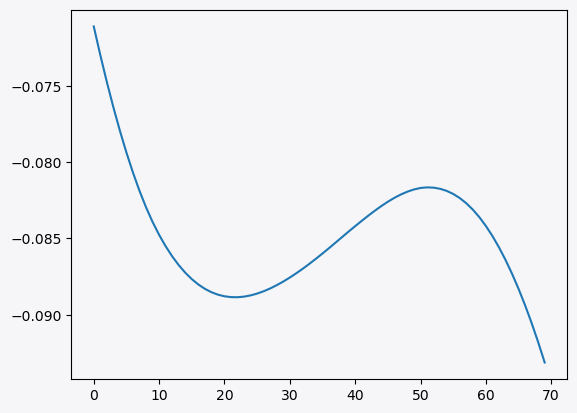

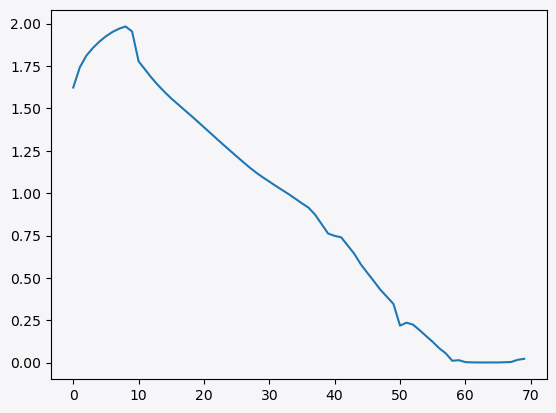

In [ ]:
# plot the trajectoy over time
plt.plot(deepc.system.y_history, label='Angle (rad)')
plt.show()
plt.plot(deepc.system.input_history, label='Torque (N.m)')


In [ ]:
# deepc.system.plot_trajectory(show_theta=setpoints, save_file='non.gif')
# from IPython.display import Image
# Image(open('non.gif','rb').read())